# Ridge Regression in Python from scratch

### 1.0 Train the model using only the numerical features

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from ipywidgets import fixed

In [2]:
import warnings
from matplotlib import MatplotlibDeprecationWarning

# Ignora il warning MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

In [3]:
def getNumericalDataFrame():
    df = pd.read_csv('dataset.csv', encoding="utf8", index_col=0)
    
    datasetDf = df.copy()    
    categoricalColumns = ['track_id','artists','album_name','track_name','explicit','track_genre']
    numericDf = datasetDf.drop( columns = categoricalColumns , axis = 1, inplace = False)
    
    #scaling
    dfMean = numericDf.mean()
    dfStd = numericDf.std()
    numericDf = (numericDf - dfMean) / dfStd
    return numericDf

In [4]:
def splitTrainTestSets(df, testSize):
    np.random.seed(8) #seed per riproducibilità
    arrayIndices = np.arange(0, len(df), 1)
    arrayTest = np.random.choice(arrayIndices, int(len(df)*testSize), replace=False)
    arrayTrain = np.setdiff1d(arrayIndices, arrayTest)
    
    arrayTest.sort()
    arrayTrain.sort()
    
    test, train = df.iloc[arrayTest], df.iloc[arrayTrain]
    
    X = train.copy()
    X = X.drop('popularity', axis = 1, inplace = False)
    X.insert(0, 'intercept', np.ones((X.shape[0],1)))
    y = train['popularity'].copy()
    
    xTest = test.copy()
    yTest = test['popularity'].copy()
    xTest = xTest.drop('popularity', axis=1, inplace = False)
    xTest.insert(0, 'intercept', np.ones((xTest.shape[0],1)))
    
    return X, y, xTest, yTest

### 2.0 Handling the categorical features

In [5]:
def getDummiesDataFrame():
    df = pd.read_csv('dataset.csv', encoding="utf8", index_col=0)
    
    dummiesDf = df.copy()
    categoricalColumns = ['track_id','artists','album_name','track_name','explicit','track_genre']
    
    for feature in categoricalColumns:
        dummiesDf[feature] = dummiesDf[feature].astype(str)
        uniqueValues = np.unique(dummiesDf[feature])
        dummiesDf[feature] = np.searchsorted(uniqueValues, dummiesDf[feature])
     
    #scaling
    dfMean = dummiesDf.mean()
    dfStd = dummiesDf.std()
    dummiesDf = (dummiesDf - dfMean) / dfStd
    return dummiesDf

### 3.0 Ridge Regression Model

In [6]:
class MyCustomModelRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, alpha):
        self.alpha = alpha
        self.theta = None
    
    def fit(self, X, y):
        # Regularization matrix
        A = np.identity(X.shape[1])
        A[0,0] = 0
        aBiased = self.alpha*A
        self.theta = np.linalg.inv(X.T.dot(X) + aBiased).dot(X.T).dot(y)
        return self
    
    def predict(self, X):
        predictions = X.dot(self.theta)
        return predictions
    
    #def score(self, xTest, yTest):
     #   predictions = np.array(self.predict(xTest))
      #  mse = mean_squared_error(yTest, predictions)
       # return mse
    
    def get_params(self, deep = True):
        return {"alpha": self.alpha}

    def set_params(self, **params):
        for parametro, valore in params.items():
            setattr(self, parametro, valore)
        return self

### 4.0 Correctness of the model

In [7]:
#init params
alpha=10
testSize = 0.8

#init dataframe
outDf = getNumericalDataFrame()
X, y, xTest, yTest = splitTrainTestSets(outDf, testSize)

#scikit Ridge
classicRidge = Ridge(alpha)
classicRidge.fit(X,y)
classicPredictions = classicRidge.predict(xTest)

#Ridge from scratch
scratchRidge = MyCustomModelRidgeRegression(alpha)
scratchRidge.fit(X,y)
scratchPredictions = scratchRidge.predict(xTest)


The mean error between the ridge predictions from scikit-learn package and my model is:  -1.6125842970281659e-18


(array([2.4100e+02, 3.7220e+03, 1.7020e+04, 4.3190e+04, 2.3471e+04,
        2.9370e+03, 4.4900e+02, 1.5600e+02, 6.0000e+00, 8.0000e+00]),
 array([-5.55111512e-16, -3.99680289e-16, -2.44249065e-16, -8.88178420e-17,
         6.66133815e-17,  2.22044605e-16,  3.77475828e-16,  5.32907052e-16,
         6.88338275e-16,  8.43769499e-16,  9.99200722e-16]),
 <BarContainer object of 10 artists>)

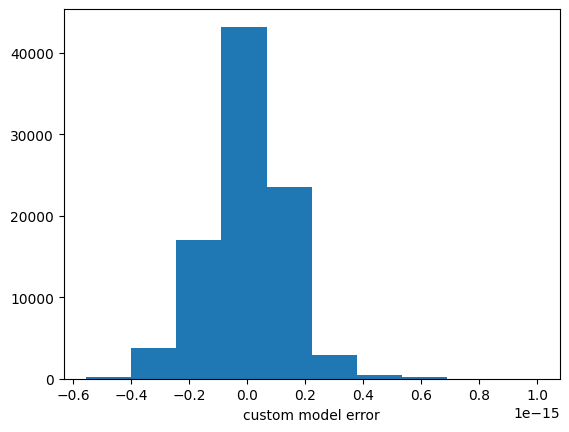

In [8]:
modelError = classicPredictions - scratchPredictions
meanModelError = modelError.mean()
print("The mean error between the ridge predictions from scikit-learn package and my model is: ",meanModelError)
plt.xlabel('custom model error')
plt.hist(modelError)

In [9]:
classicPredictions - scratchPredictions

0         9.020562e-17
1         1.665335e-16
2         8.326673e-17
3         1.665335e-16
4        -2.775558e-17
              ...     
113995    2.220446e-16
113996    1.110223e-16
113997    1.665335e-16
113998    2.775558e-17
113999    1.804112e-16
Length: 91200, dtype: float64

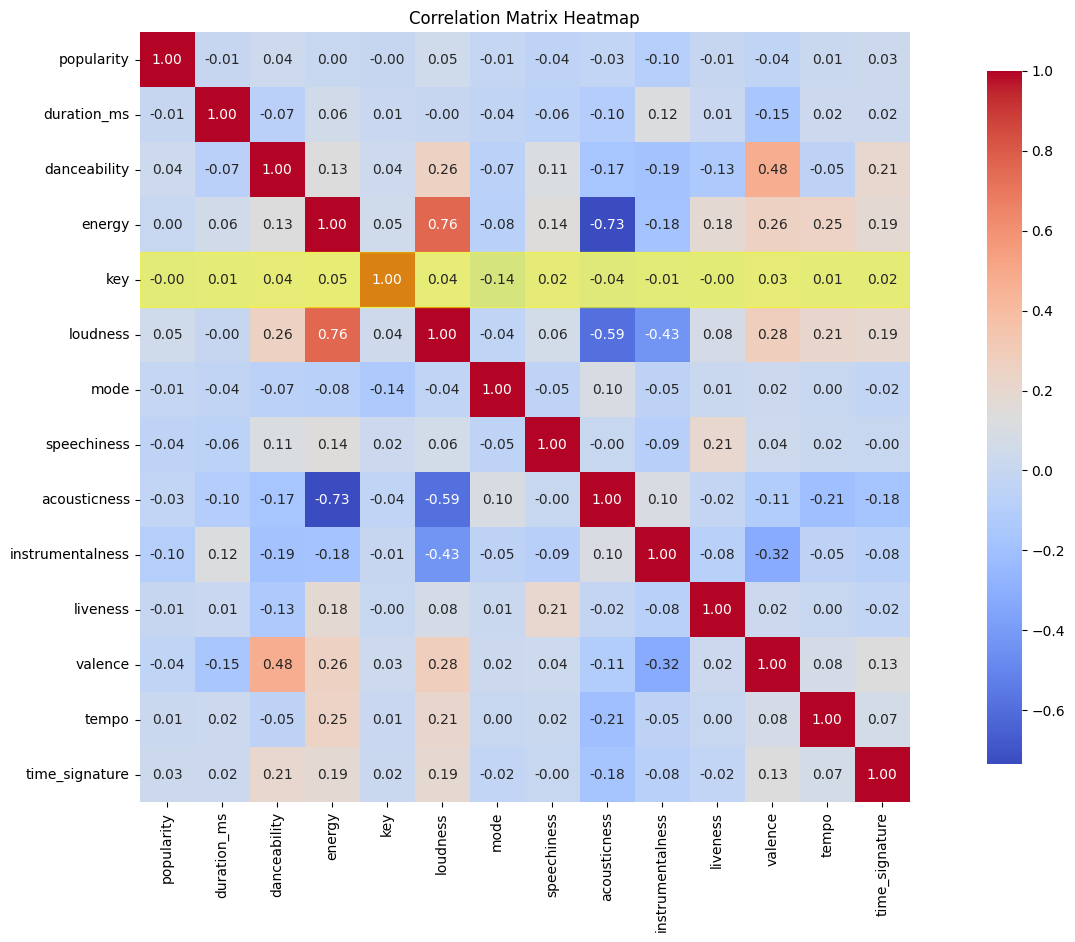

In [10]:
#correlation matrix
covarianceMatrix = outDf.cov()

#heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(covarianceMatrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .9})
plt.title('Correlation Matrix Heatmap')
highlightColumn = 4  
plt.axhspan(highlightColumn, highlightColumn + 1, color='yellow', alpha=0.5)
plt.show()

### 5.0 Experiments with numerical features only

In [11]:
def updatePlot(testSize, dataFrameType, maxAlpha):
    #init params
    alphaArray = np.linspace(0.1, maxAlpha, num = 500)
    mseArray = []
    maeArray = []
    rSquaredArray = []
    bestScoreMSE = float('inf')
    bestScoreMAE = float('inf')
    bestScoreRSquared = -float('inf')
    bestAlphaMSE = None
    bestAlphaMAE = None
    bestAlphaRSquared = None
    
    #init dataframes
    if dataFrameType == 'numerical':
        outDf = getNumericalDataFrame()
        X, y, xTest, yTest = splitTrainTestSets(outDf, testSize) 
    elif dataFrameType == 'categorical':
        outDf = getDummiesDataFrame()
        X, y, xTest, yTest = splitTrainTestSets(outDf, testSize) 
    else :
        print("invalid option for dataFrameType")
    

    #alpha loop
    for alpha in alphaArray:
        ridgeRegression = MyCustomModelRidgeRegression(alpha)
        ridgeRegression.fit(X, y)
        predictions = ridgeRegression.predict(xTest)
        
        mse = np.mean((yTest - predictions) ** 2)
        mseArray.append(mse)
        if mse < bestScoreMSE:
            bestScoreMSE = mse
            bestAlphaMSE = alpha

        
        RSS = np.sum((yTest - predictions) ** 2)
        TSS = np.sum((yTest - np.mean(yTest)) ** 2)
        r2 = 1 - (RSS / TSS)
        rSquaredArray.append(r2)  
        if r2 > bestScoreRSquared:
            bestScoreRSquared = r2
            bestAlphaRSquared = alpha

        
        mae = np.mean(np.abs(yTest - predictions))
        maeArray.append(mae)
        if mae < bestScoreMAE:
            bestScoreMAE = mae
            bestAlphaMAE = alpha
            

    #construction of the plot
    plt.figure(figsize=(22, 6))
    plt.yscale('linear')
    
    #construction of the subplot mse
    plt.subplot(1, 3, 1)
    plt.plot(alphaArray, mseArray, label='MSE')
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title('Plot of MSE with respect to alpha')
    plt.legend()
    plt.grid(True)
    mseArray = np.array(mseArray)
    print("mean MSE: ",mseArray.mean())
    print("best MSE: ", bestScoreMSE)
    print("best alpha MSE: ", bestAlphaMSE, "\n")

    #construction of the subplot r^2
    plt.subplot(1, 3, 2)
    plt.plot(alphaArray, rSquaredArray, label='R^2')
    plt.xlabel('alpha')
    plt.ylabel('R^2')
    plt.title('Plot of R-squared with respect to alpha')
    plt.legend()
    plt.grid(True)
    rSquaredArray = np.array(rSquaredArray)
    print("mean R-Squared: ",rSquaredArray.mean())
    print("best R-Squared: ", bestScoreRSquared)
    print("best alpha R-Squared: ", bestAlphaRSquared, "\n")

    #construction of the aubplot mae
    plt.subplot(1, 3, 3)
    plt.plot(alphaArray, maeArray, label='MAE')
    plt.xlabel('alpha')
    plt.ylabel('MAE')
    plt.title('Plot of MAE with respect to alpha')
    plt.legend()
    plt.grid(True)
    maeArray = np.array(maeArray)
    print("mean MAE: ",maeArray.mean())
    print("best MAE: ", bestScoreMAE)
    print("best alpha MAE: ", bestAlphaMAE, "\n")
    

In [12]:
testSizeSlider = widgets.FloatSlider(value=0.8, min=0.1, max=0.9, step=0.1, description='testSize')
maxAlphaSlider = widgets.FloatSlider(value=5000, min=0, max=200000, step=100, description='maxAlpha')
interactivePlot = widgets.interactive(updatePlot, testSize=testSizeSlider, dataFrameType='numerical', maxAlpha=maxAlphaSlider)
display(interactivePlot)

interactive(children=(FloatSlider(value=0.8, description='testSize', max=0.9, min=0.1), Text(value='numerical'…

### 6.0 Experiments including categorical features

In [13]:
testSizeSlider = widgets.FloatSlider(value=0.8, min=0.1, max=0.9, step=0.1, description='testSize')
maxAlphaSlider = widgets.FloatSlider(value=5000, min=0, max=200000, step=100, description='maxAlpha')
interactivePlot = widgets.interactive(updatePlot, testSize=testSizeSlider, dataFrameType='categorical', maxAlpha=maxAlphaSlider)
display(interactivePlot)

interactive(children=(FloatSlider(value=0.8, description='testSize', max=0.9, min=0.1), Text(value='categorica…

### 7.0 Cross Validation and Risk estimates

In [14]:
def updatePlotCV(testSize, maxAlpha, dataFrameType):
    #make some var global to use them outside the function 
    global X, y, xTest, yTest, bestAlphaMSE, bestAlphaMAE, bestAlphaRSquared
    global bestAlphaMSE, bestAlphaMAE, bestAlphaRSquared, rSquaredArrayScore, rSquaredArray
    
    
    #init params
    alphaArray = np.linspace(0.1, maxAlpha, num=500)
    mseArray = []
    maeArray = []
    rSquaredArray = []
    bestScoreMSE = float('inf')
    bestScoreMAE = float('inf')
    bestScoreRSquared = -float('inf')
    bestAlphaMSE = None
    bestAlphaMAE = None
    bestAlphaRSquared = None
    coefs = []

    #init dataframes
    if dataFrameType == 'numerical':
        outDf = getNumericalDataFrame()
        X, y, xTest, yTest = splitTrainTestSets(outDf, testSize) 
    elif dataFrameType == 'categorical':
        outDf = getDummiesDataFrame()
        X, y, xTest, yTest = splitTrainTestSets(outDf, testSize) 
    else:
        print("invalid option for dataFrameType")
        return


    #alpha loop
    for idAlpha, alpha in enumerate(alphaArray):
        
        ridgeRegression = MyCustomModelRidgeRegression(alpha)
        kf = KFold(n_splits=5)
        mseArrayScore = [] 
        maeArrayScore = []
        rSquaredArrayScore = []
        coefsFold = []  
        
        #fold loop CV
        for trainCV, testCV in kf.split(X):
            trainCV.sort()
            testCV.sort()
            XCV, XTestCV = X.iloc[trainCV], X.iloc[testCV]
            yCV, yTestCV = y.iloc[trainCV], y.iloc[testCV]
            
            #local ridge
            ridgeRegression.fit(XCV, yCV)
            predictionsCV = ridgeRegression.predict(XTestCV)
            
            #MSE
            mse = np.mean((yTestCV-predictionsCV)**2)
            mseArrayScore.append(mse)
            
            #MAE
            mae = np.mean(np.abs(yTestCV-predictionsCV))
            maeArrayScore.append(mae)
            
            #R2
            RSS = np.sum((yTestCV - predictionsCV) ** 2)
            TSS = np.sum((yTestCV - np.mean(yTestCV)) ** 2)
            r2 = 1 - (RSS / TSS)
            rSquaredArrayScore.append(r2)
            
            #folder coef
            coefsFold.append(ridgeRegression.theta)
            
        meanMse = np.mean(mseArrayScore)
        meanMae = np.mean(maeArrayScore)
        meanR2 = np.mean(rSquaredArrayScore)
        mseArray.append(meanMse)
        maeArray.append(meanMae)
        rSquaredArray.append(meanR2)    
        
        coefsFold = np.array(coefsFold)  
        coefs.append(np.mean(coefsFold, axis=0))  #media lungo asse 0 (colonna)
        
        if meanMse < bestScoreMSE:
            bestScoreMSE = meanMse
            bestAlphaMSE = alpha
            
        if meanMae < bestScoreMAE:
            bestScoreMAE = meanMae
            bestAlphaMAE = alpha
            
        if meanR2 > bestScoreRSquared:
            bestScoreRSquared = meanR2
            bestAlphaRSquared = alpha


    coefs = np.array(coefs)  

    fig, axs = plt.subplots(1, 4, figsize=(25, 8))
    
    #coef plot
    for i in range(X.shape[1]):
        axs[0].plot(alphaArray, coefs[:, i], label=X.columns[i])
    axs[0].set_xscale('log')
    axs[0].set_xlabel('alpha')
    axs[0].set_ylabel('Coefficient Value')
    axs[0].set_title('Ridge coefficients as a function of the regularization')
    axs[0].legend()
    axs[0].grid(True)
                
    #construction of the plot
    axs[1].plot(alphaArray, mseArray, label='MSE')
    axs[1].set_xlabel('alpha')
    axs[1].set_ylabel('MSE')
    axs[1].set_title('Plot of MSE CV with respect to alpha')
    axs[1].legend()
    axs[1].grid(True)
    mseArray = np.array(mseArray)
    print("mean MSE: ", mseArray.mean())
    print("best MSE: ", bestScoreMSE)
    print("best alpha: ", bestAlphaMSE)

    # Plot R-squared
    axs[2].plot(alphaArray, rSquaredArray, label='R-squared')
    axs[2].set_xlabel('alpha')
    axs[2].set_ylabel('R-squared')
    axs[2].set_title('Plot of R-squared CV with respect to alpha')
    axs[2].legend()
    axs[2].grid(True)
    rSquaredArray = np.array(rSquaredArray)
    print("mean R-squared: ", rSquaredArray.mean())
    print("best R-squared: ", bestScoreRSquared)
    print("best alpha: ", bestAlphaRSquared)
    
    
    # Plot MAE
    axs[3].plot(alphaArray, maeArray, label='MAE')
    axs[3].set_xlabel('alpha')
    axs[3].set_ylabel('MAE')
    axs[3].set_title('Plot of MAE CV with respect to alpha')
    axs[3].legend()
    axs[3].grid(True)
    maeArray = np.array(maeArray)
    print("mean MAE: ", maeArray.mean())
    print("best MAE: ", bestScoreMAE)
    print("best alpha: ", bestAlphaMAE)
    
    plt.tight_layout()
    plt.show()


In [15]:
testSizeSlider = widgets.FloatSlider(value=0.8, min=0.1, max=0.9, step=0.1, description='testSize')
maxAlphaSlider = widgets.FloatSlider(value=200000, min=0, max=200000, step=100, description='maxAlpha')
interactivePlot = widgets.interactive(updatePlotCV, testSize=testSizeSlider, dataFrameType='numerical', maxAlpha=maxAlphaSlider)
display(interactivePlot)

interactive(children=(FloatSlider(value=0.8, description='testSize', max=0.9, min=0.1), FloatSlider(value=2000…

In [16]:
print("the best MSE alpha obtained through CV is: ",bestAlphaMSE)
ridgeRegression = MyCustomModelRidgeRegression(bestAlphaMSE)
ridgeRegression.fit(X, y)
predictions = ridgeRegression.predict(xTest)
mse = np.mean((yTest-predictions)**2)
print("the risk estimate is: ",mse) 
RSS = np.sum((yTest- predictions) ** 2)
TSS = np.sum((yTest - np.mean(yTest)) ** 2)
print("r-squared is: ",1 - (RSS / TSS))
mae = np.mean(np.abs(yTest-predictions))
print("mae is: ",mae)

the best MSE alpha obtained through CV is:  3607.312625250501
the risk estimate is:  0.9735589565020158
r-squared is:  0.021800168606243564
mae is:  0.8254924898025907


In [17]:
testSizeSlider = widgets.FloatSlider(value=0.8, min=0.1, max=0.9, step=0.1, description='testSize')
maxAlphaSlider = widgets.FloatSlider(value=200000, min=0, max=200000, step=100, description='maxAlpha')
interactivePlot = widgets.interactive(updatePlotCV, testSize=testSizeSlider, dataFrameType='categorical', maxAlpha=maxAlphaSlider)
display(interactivePlot)

interactive(children=(FloatSlider(value=0.8, description='testSize', max=0.9, min=0.1), FloatSlider(value=2000…

In [ ]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X, y)
predictions = model.predict(xTest)
print(mean_squared_error(yTest, predictions))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X, y)
predictions = model.predict(xTest)
print(mean_squared_error(yTest, predictions))